Clasificación básica de imágenes con TensorFlow 2.4
===

* 30:00 min | Última modificación: Mayo 3, 2021 | [YouTube]

Adaptado de en: 

* https://www.tensorflow.org/tutorials/quickstart/beginner

* https://www.tensorflow.org/tutorials/keras/classification

![assets/fashion-mnist-sprite.png](../assets/fashion-mnist-sprite.png)

## Importación de librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.4.1


## Carga y configuración del dataset FASHION MNIST

In [2]:
#
#  Descarga de los datos
#
(
    (train_images, train_labels),
    (test_images, test_labels),
) = keras.datasets.fashion_mnist.load_data()

#
#  Nombres de las clases
#
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

print("Valor\tNombre")
print("-"*40)
for i, name in enumerate(class_names):
    print(i, "\t", name, sep="")

Valor	Nombre
----------------------------------------
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot


In [3]:
#
#  Cantidad de patrones de entrenamiento y prueba
#
train_images.shape, len(train_labels), test_images.shape, len(test_labels)

((60000, 28, 28), 60000, (10000, 28, 28), 10000)

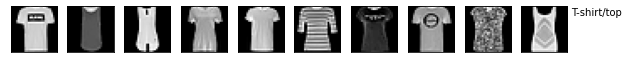

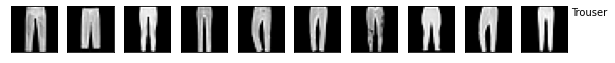

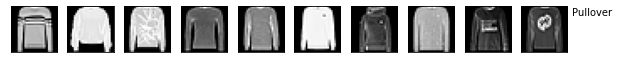

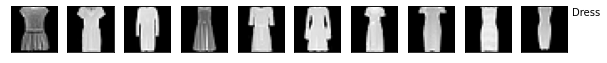

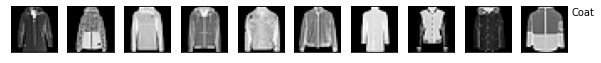

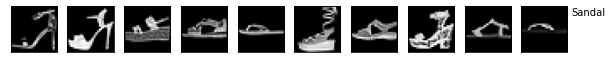

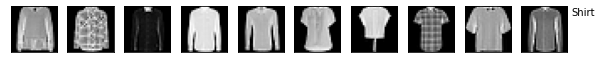

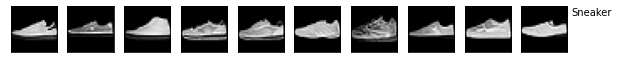

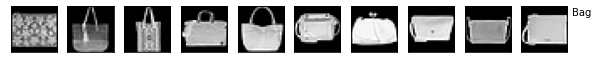

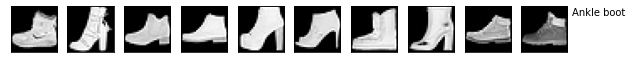

In [4]:
#
# Ejemplos de las figuras que contiene el dataset
#
def plot_mnist_examples(images, labels):
    
    # images, labels = images.copy(), labels.copy()
    
    #
    # Las figuras son de 28x28 pixels, y el
    # color va enntre 0 y 255. Se realiza la 
    # normalización del color al rango [0, 1]
    #
    images = images / 255.0
    
    data = [(img, lbl) for img, lbl in zip(images, labels)]
    for i, name in enumerate(class_names):
        plt.figure(figsize=(10, 10))
        x = [(img, lbl)  for img, lbl in data if lbl == i]       
        for j in range(10):
            plt.subplot(10, 10, i*10 + 1 + j)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(1 - x[j][0], cmap=plt.cm.binary)
        plt.text(30, 5, name)


plot_mnist_examples(train_images, train_labels)

## Especificación del modelo usando el API funcional

In [5]:
def create_model():

    inputs = keras.Input(shape=(28, 28))
    
    #
    # Esta capa reduce una dimension de la matriz de entrada.
    # El conjunto de entrada es una lista de matrices de 28x28.
    # Flatten genera una lista de vectores de dimensión 28x28
    #
    x = keras.layers.Flatten()(inputs)
    
    #
    # Preprocesamiento de la entrada [0, 255] --> [0, 1]
    #
    x = keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)(x)
   
    #
    # Esta es una capa que conecta todas las neuronas de la
    # capa anterior con todas las neuronas de la capa actual.
    #
    # Las funciones de activación disponibles son:
    #
    #  - relu (rectified linear unit):  relu(x) = max(0, x)
    #
    #  - elu (exponential linear unit): elu(x) = x if x >= 0 else exp(x) - 1
    # 
    #  - exponential: exp(x) 
    #
    #  - gelu (gaussian error linear unit): gelu(x) = x * P(X <= x)  con  P(X) ~ N(0,1)
    #
    #  - hard_sigmoid:  hard_sigmoid(x) = max(0, min(1, 0.2 * x + 0.5))
    #
    #  - linear: linear(x) = x
    #
    #  - selu (scaled exponential linear unit): selu(x) = scale * alpha *(exp(x) - 1)
    #
    #  - sigmoid: sigmoid(x) = 1 / [1 + exp(-x)]
    #
    #  - softmax: softmax(z) = exp(z_i) / sum_j (exp(z_j)) 
    #
    #  - softplus: softplus(x) = log(exp(x) + 1)
    #
    #  - softsign: softsign(x) = x / (abs(x) + 1)
    #
    #  - swish: swish(x) = x * sigmoid(x)
    #
    #  - tanh
    #
    x = keras.layers.Dense(
        128,
        activation=tf.nn.relu,
    )(x)
    
    #
    # Capa densa con un numero de neuronas igual a la cantidad 
    # de clases en el dataset
    #
    outputs = keras.layers.Dense(
        10,
        activation=tf.nn.softmax,
    )(x)

    #
    # Crea el modelo y lo retorna
    #
    model = keras.Model(
        inputs=inputs,
        outputs=outputs,
    )

    return model


#
# Creación del modelo
#
base_model = create_model()

#
# Resumen del modelo creado
#
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
rescaling (Rescaling)        (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


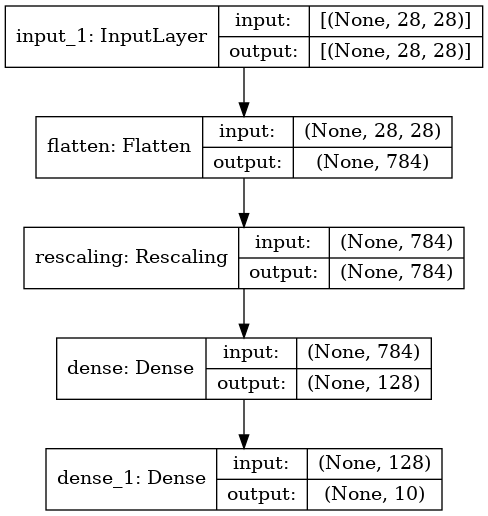

In [6]:
keras.utils.plot_model(base_model, "base_model.png", show_shapes=True)

## Propagación de la señal

In [7]:
#
# La salida del modelo son probabilidades para
# cada una de las clases. Aunque el modelo no
# esta entrenado si tiene pesos aleatorios.
#
base_model(train_images[:1]).numpy()

array([[0.07130592, 0.01924068, 0.07456226, 0.3172725 , 0.06593231,
        0.05564245, 0.03985408, 0.11872583, 0.1682849 , 0.06917904]],
      dtype=float32)

In [8]:
#
# La suma del vector de salida es ~ 1.0
#
sum(base_model(train_images[:1]).numpy()[0])

0.9999999832361937

## Construcción del modelo usando Sequential

In [9]:
#
# Resulta más práctico especificar el modelo
# como una secuencia de capas
#
base_model = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

# base_model.built()

#
# Características del modelo creado
#
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [10]:
#
# La salida del modelo son probabilidades para
# cada una de las clases. Aunque el modelo no
# esta entrenado si tiene pesos aleatorios.
#
base_model(train_images[:1]).numpy()

array([[0.13744658, 0.04229718, 0.04251578, 0.24255854, 0.09821209,
        0.01883281, 0.24985138, 0.04085545, 0.03866829, 0.0887619 ]],
      dtype=float32)

In [11]:
sum(base_model(train_images[:1]).numpy()[0])

1.0000000074505806

## Función de costo para entrenamiento del modelo

En esta lección se usará la función de entropía cruzada. Esta es una medida del desempeño del clasificador que entrega probabilidad como salida. Esta medida incrementa cuando la probabilidad pronosticada diverge de la clase actual. En clasificación binaria $y \in \{0,1\}$, la entropía se calcula como:

$$
- y \cdot \log(p) - (1 - y) \log (1-p)
$$

donde $p$ es la probabilidad de que el pronóstico sea igual a $y$

Si $y=1$, la función es $-\log(p)$; si $y=0$, la función es $-\log (1-p))$. La forma de curva de pérdida para cada caso es: 

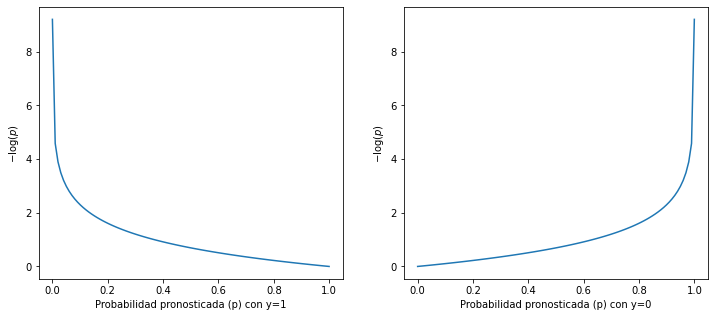

In [12]:
def plot_entropy():

    x = np.linspace(0.0001, 0.9999, 100)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, -np.log(x))
    plt.xlabel("Probabilidad pronosticada (p) con y=1")
    plt.ylabel("$-\log(p)$")

    plt.subplot(1, 2, 2)
    plt.plot(x, -np.log(1 - x))
    plt.xlabel("Probabilidad pronosticada (p) con y=0")
    plt.ylabel("$-\log(p)$")

    plt.show()


plot_entropy()

Para más de dos clases se generaliza a:

$$
- \sum d_c \cdot \log (p_c)
$$

donde $d_c$ indica que el punto pertenece a la clase $c$ y $p_c$ es su probabilidad de pertenencia (resultado del clasificador)

In [13]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    #
    # Este parametro indica que las salidas son
    # probabilidades
    #
    from_logits=True, 
)

#
# Evaluación de la función de pérdida para la
# primera imagen del conjunto de prueba
#
loss_fn(
    train_labels[:1],
    base_model(train_images[:1]).numpy(),
).numpy()

2.3171442

In [14]:
#
# Salida para el primer ejemplo de entrenamiento
#
(
    train_labels[:1],
    np.argmax(base_model(train_images[:1]).numpy()),
    base_model(train_images[:1]).numpy()[0][np.argmax(base_model(train_images[:1]).numpy())],
)

(array([9], dtype=uint8), 6, 0.24985138)

## Entrenamiento

In [15]:
#
# Compilación del modelo. En esta función se especifica:
#
# - El optimizador.
# - La función de pérdida.
# - Las metricas a monitorear.
#
base_model.compile(
    
    #
    # Especifica el algoritmo usado:
    # 
    #   * 'adadelta' : tf.keras.optimizers.Adadelta 
    #   * 'adagrad' : tf.keras.optimizers.Adagrad
    #   * 'adam' : tf.keras.optimizers.Adam
    #   * 'adamax' : tf.keras.optimizers.Adamax
    #   * 'ftrl' : tf.keras.optimizers.Ftrl
    #   * 'nadam' : tf.keras.optimizers.Nadam
    #   * 'rmsprop' : tf.keras.optimizers.RMSprop
    #   * 'sgd' : tf.keras.optimizers.SGD
    #
    # Puede usarse:
    #
    #   optimizer='adam'
    #
    optimizer=keras.optimizers.Adam(),
    
    #
    # Función de costo
    #
    #   * tf.keras.losses.BinaryCrossentropy
    #   * tf.keras.losses.CategoricalCrossentropy
    #   * tf.keras.losses.CategoricalHinge
    #   * tf.keras.losses.CosineSimilarity
    #   * tf.keras.losses.Hinge
    #   * tf.keras.losses.Huber
    #   * tf.keras.losses.KLDivergence
    #   * tf.keras.losses.LogCosh
    #   * tf.keras.losses.MeanAbsoluteError
    #   * tf.keras.losses.MeanAbsolutePercentageError
    #   * tf.keras.losses.MeanSquaredError
    #   * tf.keras.losses.MeanSquaredLogarithmicError
    #   * tf.keras.losses.Poisson
    #   * tf.keras.losses.SparseCategoricalCrossentropy
    #   * tf.keras.losses.SquaredHinge
    #
    loss=loss_fn,
    
    #
    # Define las metricas a monitorear
    #
    #   * 'accuracy' : tf.keras.metrics.Accuracy
    #   * 'binary_accuracy' : tf.keras.metrics.BinaryAccuracy
    #   * 'binary_crossentropy' : tf.keras.metrics.BinaryCrossentropy
    #   * 'categorical_accuracy' : tf.keras.metrics.CategoricalAccuracy
    #   * 'categorical_crossentropy' : tf.keras.metrics.CategoricalCrossentropy
    #   * 'categorical_hinge' : tf.keras.metrics.CategoricalHinge
    #   * 'cosine_similarity' : tf.keras.metrics.CosineSimilarity
    #   * 'hinge' : tf.keras.metrics.Hinge
    #   * 'kullback_leibler_divergence' : tf.keras.metrics.KLDivergence
    #   * 'logcosh' : tf.keras.metrics.LogCoshError
    #   * 'mean' : tf.keras.metrics.Mean
    #   * 'mean_absolute_error': tf.keras.metrics.MeanAbsoluteError
    #   * 'mean_absolute_percentage_error' : tf.keras.metrics.MeanAbsolutePercentageError
    #   * 'mean_squared_error' : tf.keras.metrics.MeanSquaredError
    #   * 'mean_squared_logarithmic_error' : tf.keras.metrics.MeanSquaredLogarithmicError
    #   * 'root_mean_squared_error': tf.keras.metrics.RootMeanSquaredError    
    #   * 'squared_hinge' : tf.keras.metrics.SquaredHinge
    #   ...
    #
    metrics=["accuracy"],
)

#
# Entrenamiento del modelo
#
history = base_model.fit(
    train_images,
    train_labels,
    epochs=10,       # Número de veces que se recorre el conjunto de entrenamiento
    verbose=1,       # 0 = silent, 1 = progress bar, 2 = one line per epoch
    batch_size=32,   # Número de muestras para la actualización del gradiente
)

# Note que 60.000 / 32 = 1875 batches

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.7335 - accuracy: 0.7465
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.6208 - accuracy: 0.8431
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.6086 - accuracy: 0.8539
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.6028 - accuracy: 0.8596
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5977 - accuracy: 0.8645
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5950 - accuracy: 0.8670
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5854 - accuracy: 0.8761
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5819 - accuracy: 0.8799
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5819 - accuracy: 0.8803
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.578

In [16]:
#
# La componente history es un diccionario con la 
# perdida para cada iteración y las metricas 
# monitoreadas.
#
history.history

{'loss': [1.6690188646316528,
  1.6209629774093628,
  1.6101200580596924,
  1.6023640632629395,
  1.5967053174972534,
  1.5938156843185425,
  1.587660789489746,
  1.5843250751495361,
  1.5818650722503662,
  1.579275369644165],
 'accuracy': [0.8030666708946228,
  0.8427833318710327,
  0.8523833155632019,
  0.8598999977111816,
  0.8652333617210388,
  0.8683333396911621,
  0.8738999962806702,
  0.8775333166122437,
  0.8799999952316284,
  0.8829333186149597]}

In [17]:
#
# La componente epoch indica la iteración
#
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Uso de un conjunto de validación durante el entrenamiento

In [18]:
history = base_model.fit(
    train_images,
    train_labels,
    epochs=10,      
    verbose=1,      
    batch_size=32,  
    
)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5764 - accuracy: 0.8852
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5741 - accuracy: 0.8880
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5722 - accuracy: 0.8895
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5709 - accuracy: 0.8910
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5689 - accuracy: 0.8926
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5686 - accuracy: 0.8924
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5658 - accuracy: 0.8957
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5644 - accuracy: 0.8974
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5638 - accuracy: 0.8977
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.561

## Evaluación y pronóstico para nuevos datos

In [19]:
#
# Evaluación para el conjunto de entrenamiento
#
train_loss, train_acc = base_model.evaluate(
    train_images,
    train_labels,
    verbose=2,
)

train_loss, train_acc

1875/1875 - 2s - loss: 1.5605 - accuracy: 0.9010


(1.5604559183120728, 0.9009666442871094)

In [20]:
#
# Evaluación para el conjunto de prueba
#
test_loss, test_acc = base_model.evaluate(test_images,  test_labels, verbose=2,)

test_loss, test_acc

313/313 - 1s - loss: 1.5859 - accuracy: 0.8752


(1.5858837366104126, 0.8751999735832214)

In [21]:
#
#  Predicción para el conjunto de test
#
predictions = base_model.predict(test_images)

#
#  Valores asignados a cada una de las clases
#  para el primer ejemplo
#
predictions[0]

array([8.41859164e-17, 2.08165168e-23, 1.08901875e-16, 1.83610731e-21,
       2.12059827e-21, 1.84957716e-09, 2.23436783e-16, 7.91318011e-10,
       2.56338830e-15, 1.00000000e+00], dtype=float32)

In [22]:
#
#  Suma de los valores asignados a cada clase para el primer
#  ejemplo. Puede asimilarse a probabilidad.
#
sum(predictions[0])

1.0000000026408982

In [23]:
#
#  Label para el que se produce el valor más alto para el primer ejemplo
#
np.argmax(predictions[0])

9

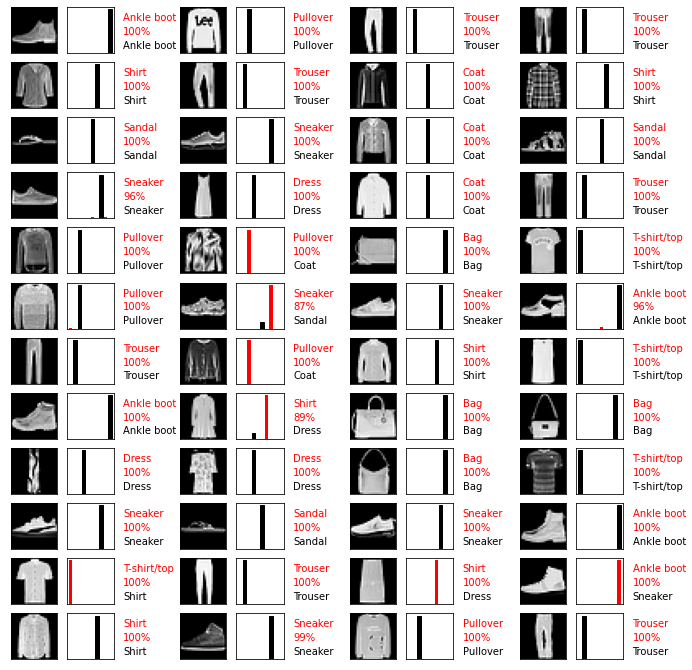

In [24]:
#
# Graficos de predicciones
#
def plot_prediction(test_images, test_labels, predictions):

    plt.figure(figsize=(12, 12))
    
    for i in range(48):
        
        plt.subplot(12, 12, i*3+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(1 - test_images[i] / 255.0, cmap=plt.cm.binary)

        plt.subplot(12, 12, i*3+2)
        plt.xticks([])
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions[i], width=0.8, color="red")
        thisplot[test_labels[i]].set_color("k")
        
        plt.subplot(12, 12, i*3+3)
        plt.xticks([])
        plt.yticks([])
        plt.box(False)
        plt.text(0, 0.1, class_names[test_labels[i]])
        plt.text(0, 0.4, "{:2.0f}%".format(100*np.max(predictions[i])), color='red')
        plt.text(0, 0.7, class_names[np.argmax(predictions[i])], color='red')


plot_prediction(test_images, test_labels, predictions)

## Uso del modelo entrenado

In [25]:
#
# Imagen a ser pronosticada
#
img = test_images[0]
img.shape  # tamaño

(28, 28)

In [26]:
#
# Keras está optimizado para generar pronósticos
# sobre colecciones, por lo que debe crearse una
# colección de una sola figura
#
img = np.expand_dims(img, 0)
img.shape

(1, 28, 28)

In [27]:
predictions_single = base_model.predict(img)

print(predictions_single, "\n\n", np.argmax(predictions_single))

[[8.4186241e-17 2.0816517e-23 1.0890270e-16 1.8361142e-21 2.1205983e-21
  1.8495807e-09 2.2343678e-16 7.9131801e-10 2.5633786e-15 1.0000000e+00]] 

 9


## Guardar y restaurar el modelo en formato SavedModel

In [28]:
#
# En este formato el modelo se debe salvar a
# una carpeta
#
!rm -rf /tmp/saved_model
!mkdir -p /tmp/saved_model
base_model.save('/tmp/saved_model/my_model')

INFO:tensorflow:Assets written to: /tmp/saved_model/my_model/assets


In [29]:
!ls /tmp/saved_model/my_model

assets	saved_model.pb	variables


In [30]:
#
# Carga el modelo a una nueva variable
#
new_model = tf.keras.models.load_model('/tmp/saved_model/my_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Guardar y restarurar del modelo en formato HDF5

In [31]:
#
# En este formato, todo el modelo queda guardado
# en un archivo
#
base_model.save('/tmp/my_model.h5')

In [32]:
new_model = tf.keras.models.load_model('/tmp/my_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


**Ejercicio.---** ¿Cómo varía la precisión del modelo con la cantidad de neuronas de la capa oculta?

## Notas

* `elu`: Exponential Linear Unit

$$
\text{elu}(x) =
\begin{cases}
x & x \ge 0 \\
\exp(x) - 1 & x \lt 0 
\end{cases}
$$

* `exponential`:

$$\exp (x)$$

* `GELU`: Gaussian Error Linear Unit 

$$
\text{GELU}(x) = x \cdot \text{P}(X \le x) \text{    con    } \text{P}(X) \sim \text{N}(0, 1)
$$

* `hard_sigmoid`:

$$
\text{hard_sigmoid}(x) = 
\begin{cases}
    0 & x \lt -2.5 \\
    0.2 \cdot x + 0.5 & -2.5 \le x \le 2.5 \\
    1 & x \gt 2.5
\end{cases}
$$

* `linear`:

$$
\text{linear}(x) = x
$$

* `relu`:

$$
\text{relu}(x) = \max(0, x)
$$

* `selu`: scaled exponential lineal

$$
\text{selu}(x) = \text{scale} \cdot \text{alpha} \cdot (\exp(x) - 1)
$$

* `sigmoid`: 

$$\text{sigmoid}(x) = \frac{1}{1+\exp(-x)}$$

* `softmax`: recibe un vector de valores $z_j$ en el rango [0, 1]. Retorna un vector de igual tamaño con:

$$
\frac{\exp(z_j)}{\sum_i \exp(z_i)}
$$


* `softplus`:

$$\text{softplus}(x) = \log(\exp(x) + 1)$$

* `softsign`:

$$\text{softsign}=\frac{x}{\text{abs}(x) + 1}$$

* `swish`:

$$\text{swish}=x \cdot \text{sigmoid}(x)$$

* `tanh`: tangente hiperbólica

In [33]:
#
# Nombre y dimensiones de salida de la capas
#
for layer in base_model.layers:
    print(layer.name,  layer.output_shape)

flatten_1 (None, 784)
rescaling_1 (None, 784)
dense_2 (None, 128)
dense_3 (None, 10)


In [34]:
#
# Parametros entrenables
#
for v in base_model.trainable_weights:
    print(v.numpy())
    print()

[[ 0.17960252  0.17351955 -0.03724453 ...  0.02799553  0.27073574
  -0.38445678]
 [ 0.03801466  0.12859215  0.49137717 ...  0.01400005  0.23114173
   0.20656006]
 [ 0.32591516 -0.0437136  -0.09612004 ... -0.06381944 -0.15167014
  -0.33355907]
 ...
 [-0.12181602  0.26843476 -0.16009103 ...  0.07296633  0.544136
   0.0587844 ]
 [ 0.0171589   0.22482812 -0.27387398 ... -0.0330082   0.4042067
  -0.0585301 ]
 [-0.17707217 -0.08057234 -0.0463464  ... -0.05599747  0.19049548
  -0.11058754]]

[ 0.15997839  0.43445393  0.2871251  -0.66245264 -0.7647436  -0.6561872
 -0.72127455 -0.7392191  -0.48645535 -1.2745054  -0.0214639   0.46505162
  0.20003243  0.5007693  -0.02726789  0.0186174   0.09121236 -0.09553633
  0.4695439  -0.04344399  0.27976865  0.760634   -0.01049773  0.6033778
  0.5025331   0.7381782   0.33736536  1.0148962   0.01246591  0.29538533
  0.13425462 -0.25899774 -0.09170602 -0.65642774 -0.01165441  0.27020103
  0.75134605  0.1072161   0.3714291  -0.06710611 -0.01639533 -0.02305915
 

## layers.Flatten

In [35]:
#
# La capa Flatten reduce en una dimensión 
# la matriz de entrada
#
x = tf.random.normal((2, 3, 4))
print(x)
print()
keras.layers.Flatten(input_shape=(2,3))(x)

tf.Tensor(
[[[-0.64467674  0.18176    -1.3300685   1.1317878 ]
  [ 1.3406023  -1.3666005   0.10968371  0.9419749 ]
  [-0.26949584  0.40712512 -0.08631007  1.1524502 ]]

 [[-0.9614313   0.9052183  -0.50256675  1.0210325 ]
  [-1.071695    0.9044744   0.04893233 -0.20479736]
  [ 2.597699   -0.92622435 -1.6585608   0.749733  ]]], shape=(2, 3, 4), dtype=float32)



<tf.Tensor: shape=(2, 12), dtype=float32, numpy=
array([[-0.64467674,  0.18176   , -1.3300685 ,  1.1317878 ,  1.3406023 ,
        -1.3666005 ,  0.10968371,  0.9419749 , -0.26949584,  0.40712512,
        -0.08631007,  1.1524502 ],
       [-0.9614313 ,  0.9052183 , -0.50256675,  1.0210325 , -1.071695  ,
         0.9044744 ,  0.04893233, -0.20479736,  2.597699  , -0.92622435,
        -1.6585608 ,  0.749733  ]], dtype=float32)>

In [36]:
#
# Dimensiones de la salida de una capa Flatten
#
demo_model = keras.Sequential()
demo_model.add(keras.layers.Flatten(input_shape=(2,3)))
demo_model.output_shape

(None, 6)

## layers.Dense

In [37]:
#
# Dense: es una capa que conecta todas las entradas 
# a todas las neuronas de la capa
#
demo_model = keras.Sequential()
demo_model.add(keras.layers.Dense(
    units=3,
    activation=None, # Si es None se usa Linear(x) = x
    use_bias=True,
    input_shape=(2,)),
)
demo_model.output_shape

(None, 3)

## Activation

## Ejemplo de propagación de una señal

In [38]:
#
# Propagación de la señal
#
x = tf.random.normal((4, 2))
x

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.992935  , -1.4068913 ],
       [-0.17538324, -1.3184577 ],
       [-1.2444159 , -1.3101307 ],
       [-0.4559462 ,  0.359195  ]], dtype=float32)>

In [39]:
demo_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [40]:
#
# Capa de entrada --> capa salida
#
demo_model.layers[0].weights[0].numpy()

array([[ 0.45269787,  0.35395277,  0.7412696 ],
       [-0.6578557 , -0.46898448,  0.3286829 ]], dtype=float32)

In [41]:
#
# Bias capa de salida
#
demo_model.layers[0].weights[1].numpy()

array([0., 0., 0.], dtype=float32)

In [42]:
demo_model.predict(x)

array([[ 0.47603187,  0.3083581 , -1.1984537 ],
       [ 0.78795934,  0.5562588 , -0.56336075],
       [ 0.29853255,  0.17396653, -1.3530653 ],
       [-0.44270435, -0.3298403 , -0.2199178 ]], dtype=float32)

In [43]:
#
# Primer patron de entrada a la primera neurona oculta
#
#       x1 *         w1 +         x2 *        w2 + w0
0.34032142 * 0.98092103 + -0.2889726 * 0.3135172 + 0.

0.24323055740874255

In [44]:
#
# Primer patrón de entrada a la segunda neurona oculta
#
#       x1 *         w1 +         x2 *         w2 + w0
0.34032142 * 0.86922000 + -0.2889726 * 0.57068133 + 0.

0.130902916990842

In [45]:
#
# Nombre y dimensiones de salida de la capas
#
for layer in base_model.layers:
    print(layer.name,  layer.output_shape)

flatten_1 (None, 784)
rescaling_1 (None, 784)
dense_2 (None, 128)
dense_3 (None, 10)


In [46]:
#
# Parametros entrenables
#
for v in base_model.trainable_weights:
    print(v.numpy())
    print()

[[ 0.17960252  0.17351955 -0.03724453 ...  0.02799553  0.27073574
  -0.38445678]
 [ 0.03801466  0.12859215  0.49137717 ...  0.01400005  0.23114173
   0.20656006]
 [ 0.32591516 -0.0437136  -0.09612004 ... -0.06381944 -0.15167014
  -0.33355907]
 ...
 [-0.12181602  0.26843476 -0.16009103 ...  0.07296633  0.544136
   0.0587844 ]
 [ 0.0171589   0.22482812 -0.27387398 ... -0.0330082   0.4042067
  -0.0585301 ]
 [-0.17707217 -0.08057234 -0.0463464  ... -0.05599747  0.19049548
  -0.11058754]]

[ 0.15997839  0.43445393  0.2871251  -0.66245264 -0.7647436  -0.6561872
 -0.72127455 -0.7392191  -0.48645535 -1.2745054  -0.0214639   0.46505162
  0.20003243  0.5007693  -0.02726789  0.0186174   0.09121236 -0.09553633
  0.4695439  -0.04344399  0.27976865  0.760634   -0.01049773  0.6033778
  0.5025331   0.7381782   0.33736536  1.0148962   0.01246591  0.29538533
  0.13425462 -0.25899774 -0.09170602 -0.65642774 -0.01165441  0.27020103
  0.75134605  0.1072161   0.3714291  -0.06710611 -0.01639533 -0.02305915
 

## layers.Flatten

In [47]:
#
# La capa Flatten reduce en una dimensión 
# la matriz de entrada
#
x = tf.random.normal((2, 3, 4))
print(x)
print()
keras.layers.Flatten(input_shape=(2,3))(x)

tf.Tensor(
[[[ 0.00844942 -1.5968869  -2.5306973   0.4053643 ]
  [-0.50902665  1.1745054   1.4248923  -0.2231901 ]
  [-0.46089143 -0.13902661 -1.4907935  -1.5590836 ]]

 [[ 1.0881402  -0.69093937  0.263135   -0.831647  ]
  [ 0.08176146  0.91395146  1.1371495   2.3725212 ]
  [-2.1898298   0.9076816  -0.96704954 -0.5190284 ]]], shape=(2, 3, 4), dtype=float32)



<tf.Tensor: shape=(2, 12), dtype=float32, numpy=
array([[ 0.00844942, -1.5968869 , -2.5306973 ,  0.4053643 , -0.50902665,
         1.1745054 ,  1.4248923 , -0.2231901 , -0.46089143, -0.13902661,
        -1.4907935 , -1.5590836 ],
       [ 1.0881402 , -0.69093937,  0.263135  , -0.831647  ,  0.08176146,
         0.91395146,  1.1371495 ,  2.3725212 , -2.1898298 ,  0.9076816 ,
        -0.96704954, -0.5190284 ]], dtype=float32)>

In [48]:
#
# Dimensiones de la salida de una capa Flatten
#
demo_model = keras.Sequential()
demo_model.add(keras.layers.Flatten(input_shape=(2,3)))
demo_model.output_shape

(None, 6)

## layers.Dense

In [49]:
#
# Dense: es una capa que conecta todas las entradas 
# a todas las neuronas de la capa
#
demo_model = keras.Sequential()
demo_model.add(keras.layers.Dense(
    units=3,
    activation=None, # Si es None se usa Linear(x) = x
    use_bias=True,
    input_shape=(2,)),
)
demo_model.output_shape

(None, 3)

## Activation

## Ejemplo de propagación de una señal

In [50]:
#
# Propagación de la señal
#
x = tf.random.normal((4, 2))
x

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.5264758 , -2.3515544 ],
       [ 0.5552021 , -0.52304447],
       [ 0.9140404 , -0.2414003 ],
       [-0.47359392,  0.7575429 ]], dtype=float32)>

In [51]:
demo_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [52]:
#
# Capa de entrada --> capa salida
#
demo_model.layers[0].weights[0].numpy()

array([[-0.1503132 , -0.39359462, -0.689906  ],
       [ 0.12399995,  0.81775534,  1.0093153 ]], dtype=float32)

In [53]:
#
# Bias capa de salida
#
demo_model.layers[0].weights[1].numpy()

array([0., 0., 0.], dtype=float32)

In [54]:
demo_model.predict(x)

array([[-0.21245638, -1.7157781 , -2.010241  ],
       [-0.1483117 , -0.64624697, -0.910954  ],
       [-0.16732596, -0.55716777, -0.87425095],
       [ 0.1651227 ,  0.8058888 ,  1.0913349 ]], dtype=float32)

In [55]:
#
# Primer patron de entrada a la primera neurona oculta
#
#       x1 *         w1 +         x2 *        w2 + w0
0.34032142 * 0.98092103 + -0.2889726 * 0.3135172 + 0.

0.24323055740874255

In [56]:
#
# Primer patrón de entrada a la segunda neurona oculta
#
#       x1 *         w1 +         x2 *         w2 + w0
0.34032142 * 0.86922000 + -0.2889726 * 0.57068133 + 0.

0.130902916990842